# MPCS 53111 - Homework 2

## name: Zhenyang Lu

# Question 1

# Part A

Applying bottom-up, chis-quare prune is going to prune out irrelevant attribute. 

I'm not really sure what's going to happen if we apply chi-square prune in top down way. But it sounds like the "early stopping" issue, if we do it, which stops us from recognizing situations where there is no one good attribute, but there are combinations of attributes that are informative. Anyway, the point is, applying it top down would be a bad idea. 

Code used to generate dataset follows: 

In [10]:
import pandas as pd

a = [1,1,1,1,0,0,0,0]
b= [True,True,False,False,True,True,False,False]
c= [1,1,3,3,3,3,1,1]

a = pd.Series(a)
b = pd.Series(b)
y = pd.Series(c)

x = pd.concat([a,b],axis=1) 
z = pd.concat([a,b,y],axis=1)

# columns [0,1] contains two independent variables
# column [2] is dependent variable

z

,0,1,2
0,1,True,1
1,1,True,1
2,1,False,3
3,1,False,3
4,0,True,3
5,0,True,3
6,0,False,1
7,0,False,1


# part B

Please be advised that, I'm not creating a new set of code for prune(), instead, I modified code for homework 1, so that each node on Decision tree contains the dataset before splitting. With that change, my prune() function takes a node on a decision tree and confidence level of chi-square test as input, output a bool value to signal whether we should prune a specific node(attribute). True means we could reject null hypothesis that the attribute is irrelevant, which means we should not prune it. False means we should prune the input node, which represents an attribute. 

For now, I'm not going to code a sophisticated prune() method, rather just a simple one, which can handle continuous and categorical data, to show the idea of how to do it. This method can be extended to a more robust method to return a pruned decision tree model object with more efforts.  

I will use the dataset created in PART A as an example to show how does my prune() works. As you could verify, this simple dataset should enable a depth 2 decision tree to be modeled, and the root is kind of irrelevant, because information gain of the root is really 0, so my prune() method in DecisionTree class should answer "False", which means we should not reject the null hypothesis and prune it out. 

Prune() method has been put on top of DecisionTree class, right after _init_ for you to review. The rest is irrelevant to this homework. 

In [15]:
import scipy.stats as stats
import math
import numpy as np
import pandas as pd
import os
import gc
import time

# this class simulate a binary tree structure to remember the fitted model
class treenode():
    def __init__(self,attribute_index = None, gain = 0, split = None, value = None, left_child = None, right_child = None, X=None, y=None):
        
        """
        attribute_index: The index of feature splitted at this point.
        split: If the attribute is continuous, split is on which value we split.
        value: If the node is leaf, set it.
        left_child: linked child node
        right_child: 
        """
        
        self.attribute_index = attribute_index
        self.split = split
        self.value = value
        self.left_child = left_child
        self.right_child = right_child
        self.gain = gain
        
        # store the unfitted data, just for my own debugging 
        self.X = X
        self.y = y
    
# each instance of DecisionTree can only be used to fit a single model, don't 
# fit twice with same instance. 

class DecisionTree():
    
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        
        # self.root is the binary tree structure that stores the 
        # fitted model.
        self.root = None
        
        # assume label column contains only two kinds of labels
        # ya is one
        # yb is the other
        self.ya =None ;
        self.yb =None ;
        
        self.max_depth = max_depth;
        
        # ya is the target classification in label column
        self.target_classification=None;
       
    
    
    # REVIEW PRUNE()

    # node is the tree node(treenode object) in decision tree model, 
    # you want to test to prune return True, which means: we can 
    # reject the null hypothesis that the attribute being test is 
    # irrelevant, so True means we can not prune the current attribute
    # False means we could prune out the current attribute
    
    def prune(self, node, alpha):   
        
        # every variable in this function is the same as that with the
        # same name in textbook 18.3.5 
        z = pd.concat([node.X,node.y],axis=1,names=['x','y'])
        
        # NOTICE: THIS CLASS CAN ONLY HANDLE BINARY DECISION TREE! 
        #         SO 2 MEANS THIS IS BINARY TREE
        # Notice: things can be potentially improved here: 
        #         put self.ya and self.yb in a list
        delta = 0 
        
        # continuous data column
        if node.X[node.attribute_index].dtype in ('int64','float64'):

            n = sum(node.y <= self.yb)
            p = sum(node.y > self.ya)
                    
            for i in [self.ya,self.yb]:
                pk = sum(z[z.iloc[:,node.attribute_index] == node.split].iloc[:,-1] <= self.ya)
                nk = sum(z[z.iloc[:,node.attribute_index] == node.split].iloc[:,-1] > self.yb)         
    
                pk_cap = p*(pk+nk)/(p+n)
                nk_cap = n*(pk+nk)/(p+n)
                
                delta = delta + ((pk-pk_cap)**2/pk_cap + (nk-nk_cap)**2/nk_cap) 
                        
        # categorical data column        
        else:
            n = sum(node.y==self.yb)
            p = sum(node.y==self.ya)
                    
            for i in [self.ya,self.yb]:
                pk = sum(z[z.iloc[:,node.attribute_index] == node.split].iloc[:,-1] == self.ya)
                nk = sum(z[z.iloc[:,node.attribute_index] == node.split].iloc[:,-1] == self.yb)         
    
                pk_cap = p*(pk+nk)/(p+n)
                nk_cap = n*(pk+nk)/(p+n)
                
                delta = delta + ((pk-pk_cap)**2/pk_cap + (nk-nk_cap)**2/nk_cap) 

        # calculate p-value
        p_value = 1 - stats.chi2.cdf(delta,df=p+n-1)
        
        if float(p_value) < alpha:
            # True means we could not prune the current node. 
            return True
        
        else:
            return False
  



    # target_classification is the label you want to learn 
    # candidate_attribute_index is a index instatnce specifying
    # which columns to use as indepedent variables. 
    
    # this method is a wrapper than calls _tree_learning(), 
    # which is the recursive function to build model. 
    
    # it returns a treenode instance to self.root, which can be seen by 
    # self.print()

    
    def fit(self, X,y,target_classification, candidate_attribute_index=None):  
        
        # what's candidate_attributes
        if candidate_attribute_index is None:
            candidate_attribute_index = X.columns

        self.target_classification  = target_classification
        
        # error checking 
        if X.empty or len(candidate_attribute_index) == 0 or self.target_classification is None: 
            print("Can not build Decision Tree on empty dataset or no candidate index")
            return 

        # if we only want to fit based on specific attributes, then just keep 
        # those in question. 
             
        X = X[candidate_attribute_index]

        # fill missing with most common values
        for i in candidate_attribute_index:
            if X[i].isnull().values.any():
                X[i] = X[i].fillna(X[i].value_counts().idxmax()) 

        self.ya,self.yb = y.unique()
                   
        for i in range(len(y)):
            #print(y[0])
            if y[i] !=  self.target_classification:
                y[i] = self.yb

        # reindex                
        index_count = X.shape[1] + 1
        dataset = pd.concat([X[candidate_attribute_index],y],axis=1)
        
        dataset.columns =[i for i in range(index_count)]

        self.root = self._tree_learning(dataset,current_depth=1)
        
        return self.root
    
            
    # label column is always the last column in dataset
    # this function return a treenode object to self.root
    
    def _tree_learning(self,dataset, parent_dataset=None, last_split_on=None,current_depth = None):
        
        if dataset.empty:
            return
        
        if current_depth >= self.max_depth:
            
            n = len(parent_dataset[parent_dataset[parent_dataset.columns[-1]]==self.yb])
            p = len(parent_dataset[parent_dataset[parent_dataset.columns[-1]]==self.ya])

            if n == 0 and p == 0:
                print(parent_dataset)
                
            value = p/(p+n)
            
            return treenode(attribute_index = last_split_on, value = value, X = dataset.iloc[:,0:-1], y = dataset.iloc[:,-1])
            
        # if the current dataset is empty return.
        if len(dataset.columns)==1:

            n = len(dataset[dataset[dataset.columns[0]]==self.yb])
            p = len(dataset[dataset[dataset.columns[0]]==self.ya])
         
            value = p/(p+n)

            return treenode(attribute_index = last_split_on,value = value, X = dataset.iloc[:,0:-1], y = dataset.iloc[:,-1])   

            
        # attributes set is empty
        elif len(dataset.columns) ==2 and len(dataset[dataset.columns[0]].unique())==1:

            n = len(dataset[dataset[dataset.columns[1]]==self.yb])
            p = len(dataset[dataset[dataset.columns[1]]==self.ya])
         
            value = p/(p+n)

            return treenode(value = value,split = last_split_on,  X = dataset.iloc[:,0:-1], y =dataset.iloc[:,-1])
     
            
        # all examples have the same classification
        elif len(dataset.iloc[:,-1].unique()) ==1:
 
            n = len(parent_dataset[parent_dataset[parent_dataset.columns[-1]]==self.yb])
            p = len(parent_dataset[parent_dataset[parent_dataset.columns[-1]]==self.ya])

            if n == 0 and p == 0:
                print(parent_dataset)
                
            value = p/(p+n)
            
            return treenode(attribute_index = last_split_on, value = value,  X = dataset.iloc[:,0:-1], y =dataset.iloc[:,-1])

        else: 
            
            # factor[0] = information gain,
            # factor[1] = split index
            # factor[2] = split value
            factor = self.most_important(dataset)
            
            # this column is a categorical value
            if type(factor[2]) == list:
                # left takes positive value             
                left_node = self._tree_learning(dataset[dataset[factor[1]] == factor[2][0]].iloc[:,dataset.columns!=factor[1]],dataset,last_split_on=factor[1],current_depth=current_depth+1)
                right_node = self._tree_learning(dataset[dataset[factor[1]] != factor[2][0]].iloc[:,dataset.columns!=factor[1]],dataset,last_split_on=factor[1],current_depth=current_depth+1)
            
            # continuous value
            else:            
                left_node = self._tree_learning(dataset[dataset[factor[1]] <= factor[2]].iloc[:,dataset.columns!=factor[1]],dataset,last_split_on=factor[1],current_depth=current_depth+1)
                right_node = self._tree_learning(dataset[dataset[factor[1]] > factor[2]].iloc[:,dataset.columns!=factor[1]],dataset,last_split_on=factor[1],current_depth=current_depth+1)
            
            return treenode(attribute_index=factor[1],gain = factor[0], split=factor[2],left_child = left_node, right_child = right_node,  X = dataset.iloc[:,0:-1], y =dataset.iloc[:,-1])        
    
    # predict values based on self.root
    # the predicted values are stored on
    # the last column of input T
    # this function calls predict_traverse()
    # and returns T with the last column as predicted
    # value
    
    def predict(self, T):
        
        # last column stores the predicted values
        T[T.shape[1]] = pd.Series([])

        T.index = [i for i in range(T.shape[0])]
        
        for i in range(T.shape[0]):
            T.ix[i]=self.predict_traverse(self.root,T.ix[i])      
            
    
    def predict_traverse(self,tree,a):

        if tree is None:
            return 
        
        # if this is internal node
        elif tree.value is None:
           
            # if categorical data
            if type(tree.split) == list:
                
                if a[tree.attribute_index] == tree.split[0]:
                    return self.predict_traverse(tree.left_child,a)
                else:
                    return self.predict_traverse(tree.right_child,a)                
                
            # if continuous data
            else:
                # if <= split, go to left tree
                if a[tree.attribute_index] <= tree.split:
                    return self.predict_traverse(tree.left_child,a)
                else:
                    return self.predict_traverse(tree.right_child,a)
        
        # if this is leaf
        else: 
            if np.random.random() <= tree.value :
                return a.set_value(a.shape[0]-1,self.ya)
                
            else:
                return a.set_value(a.shape[0]-1,self.yb)
            
        
    # this method prints out the fitted binary decision tree
    # PLEASE pardon me for printing out in a ugly way, I don't 
    # really have an idea of how a pretty way to do it should 
    # look like
    # This method is a wrapper that calls tree_traverse(), which
    # is an recursive function to print out self.root
    
    # this function returns a ugly binary tree. 
    
    def print(self):
        print("               DESCRIPTION                         ")
        print("-------------------------------------------------- ")
        print("MAX DEPTH: ", self.max_depth)
        print("RULE: Decision tree being fitted is always binary  ")
        print("      left child is smaller than the split value of")
        print("      parent node if it's a continous value, or the")
        print("      first value of list, if it's a binary value ")
        print("      -> denote depth of the current tree node, so")
        print("      -> is depth 2, ->-> denote a depth of 3, etc.")
        print("-------------------------------------------------- \n")
        
        self.tree_traverse(self.root)    
    
    # "->" means one more level of tree
    def tree_traverse(self,node = None,indent = "->"):
        
        if node is None:
            print("Tree is empty")
            
        else:
            if node.value is not None:
                print(node.value)
                
            else:
                print ("split index[%s] by value %s " % (node.attribute_index, node.split))

                print ("%s %s: " % (indent,"left node"),end="")
                self.tree_traverse(node.left_child,indent + "->")

                print ("%s %s: " % (indent,"right node"),end="")
                self.tree_traverse(node.right_child,indent + "->")

                
    # this method assumes  the last column in dataset is the class attribute
    # this is the core method of this class, it loop through indepedent (X) 
    # variables and tells which one is the best to divide. 
    # this method can handles both categorical and continuous data type.
    
    # it returns current best column(index) to split 
    def most_important(self,dataset):
    
        best_split = None
        max_gain = -math.inf
        split_col = None

        for i in dataset.columns[0:-1]:

            # if the column is continuous
            if dataset[i].dtype in ('int64','float64'):
                
                dataset = dataset.sort_values(i,ascending=[1])
                dataset.index = range(0,len(dataset))
                
                for j in range(len(dataset[i])-1):
                    
                    if dataset.iloc[:,-1][j] != dataset.iloc[:,-1][j+1]:
                        #print (dataset.iloc[:,-1][j], dataset.iloc[:,-1][j+1],j)
                        split = (dataset[i][j]+dataset[i][j+1])/2                        
                        gain = self.information_gain_continuous(dataset[i], dataset.iloc[:,-1],split)
                        
                        if max_gain < gain:
                            max_gain = gain
                            best_split = j
                            split_col = i                            
                            
            # if the column is binary 
            else: 
                gain = self.information_gain_category(dataset[i],dataset.iloc[:,-1])
                
                if max_gain < gain:
                    max_gain = gain
                    best_split = list(dataset[i].unique())
                    split_col = i
        
                    
        if type(best_split) == list:
            
            return max_gain, split_col, best_split
            
        else:
      
            best_split = dataset[split_col][best_split]
            
            return max_gain, split_col, best_split    
            
    # assume y contains only two unique values
    #        x is categorical data. 
    # this function calculates information gain  
    # of a column that has categorical data
    
    # it returns information gain value
    def information_gain_category(self,x,y):
         
        p = y[y==self.ya].count()
        n = y[y==self.yb].count()
        
        sum = self.entropy(p,p+n)
        z = pd.concat([x,y],axis=1,names=['x','y'])
        
        for i in x.unique():  
            
            pk =  z[z[z.columns[0]] ==i][z[z.columns[1]] == self.ya].count()[z.columns[0]]
            pn =  z[z[z.columns[0]] ==i][z[z.columns[1]] == self.yb].count()[z.columns[1]]
    
            sum = sum - (pk+pn)/(p+n)*self.entropy(pk,pk+pn)

        return sum 
        
    # assume z contains both x and y, which are
    # independent and dependent variables.
    # split is a value on which we split x. 
    
    # this method needs modification if we are fitting 
    # a Decision tree that's not binary. 
    
    # it returns information gain value
    def information_gain_continuous(self,x,y,split):
        
        z = pd.concat([x,y],axis=1,names=['x','y'])
                
        p = z[z.columns[1]][z[z.columns[1]]==self.ya].count()
        n = z[z.columns[1]][z[z.columns[1]]==self.yb].count()
        
        sum = self.entropy(p,p+n)
                                
        pk =  z[z[z.columns[0]] <= split][z[z.columns[1]] == self.ya].count()[z.columns[1]]
        pn =  z[z[z.columns[0]] <= split][z[z.columns[1]] == self.yb].count()[z.columns[1]]
        
        sum = sum - (pk+pn)/(p+n)*self.entropy(pk,pk+pn)

        pk =  z[z[z.columns[0]] > split][z[z.columns[1]] == self.ya].count()[z.columns[1]]
        pn =  z[z[z.columns[0]] > split][z[z.columns[1]] == self.yb].count()[z.columns[1]]
  
        return sum - (pk+pn)/(p+n)*self.entropy(pk,pk+pn) 
    
    # this is a toy method to calculate entropy
    # notice this method's parameter n and p
    # which are nominator and denominator
    # it returns entropy(n/d)
    
    def entropy(self,n,d):
    
        if d == 0 or n==d or n ==0:
            return 0
    
        else: 
            p = n/d
            return -(p*math.log2(p) + (1-p)*math.log2(1-p))
        
# create a DecisionTree object
n = DecisionTree(3)
# fit a model for the dataset from part A
n.fit(x,y,target_classification=1)

# test if we need to prune the root node with .95 confidence 
# again, False means we should prune the attribute being test out
# notice: attribute index being tested is the index of column being tested in original dataset,

print('Current attribute index being tested:', n.root.attribute_index) 
n.prune(n.root,alpha = 0.05)        

Current attribute being tested: 0


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:429: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:430: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:434: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:435: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:405: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:406: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


False

In order for you to compare the result with the original dataset, let's print out the DecisionTree model output by my DecisionTree class, assuming we are now fitting a model to predict those row with the dependent variable as 1. 

In [16]:
n.print()

               DESCRIPTION                         
-------------------------------------------------- 
MAX DEPTH:  3
RULE: Decision tree being fitted is always binary  
      left child is smaller than the split value of
      parent node if it's a continous value, or the
      first value of list, if it's a binary value 
      -> denote depth of the current tree node, so
      -> is depth 2, ->-> denote a depth of 3, etc.
-------------------------------------------------- 

split index[0] by value 0 
-> left node: split index[1] by value [True, False] 
->-> left node: 0.5
->-> right node: 0.5
-> right node: split index[1] by value [True, False] 
->-> left node: 0.5
->-> right node: 0.5


In [17]:
# column 2 is the dependent variable
print(z)

   0      1  2
0  1   True  1
1  1   True  1
2  1  False  3
3  1  False  3
4  0   True  3
5  0   True  3
6  0  False  1
7  0  False  1


# Question 2 

# Part A

This problem can be tackled by a simulation as follows: 
Assume we are working on a x1 ~ x2 plane whose length and height are both n. Suppose a distinct rectangle's upper left coordinate is (b,d), and lower right coordinate is (a,c). we could count all distinct rectangles within the plane by the following code: 

In [21]:
def count(n):

    count = 0
    
    for d in range(0,n+1):
        for b in range(0,n+1):
            for a in range(0,n+1):
                for c in range(0,n+1):
                    if b > a and d > c and b>0 and d>0:
                        count = count +1
                    else:
                        break
                    
    return count

count(10)

3025

as you could verify when n = 10, $(\frac{n(n+1)}{2})^2$ = 3025, which is the same as the result of count(10)

# Part B

Let N denote the number of training examples

Let $\epsilon$ denote the generalization error, which is 0.1

Let $\delta$ denote probability bound, which is 0.95. 

Let |H| denote the hypothesis space, which is $(\frac{n(n+1)}{2})^2$

So $N >= \frac{1}{\epsilon}(\ln\frac{1}{\delta} + \ln (| H|)) = 0.513 + 20*ln(\frac{n(n+1)}{2})$

# Question 4

the following is a function called quadratic_cohen_kappa(y1,y2), which takes two pandas series as input and output quadratic cohen kappa number.   

In [2]:
import numpy as np
import pandas as pd
from time import time
from scipy.stats import mode
from sklearn.preprocessing import Imputer
from sklearn import tree
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

# x is input matrix

def quadratic_cohen_kappa(y1,y2):
    
    y = pd.concat([y1,y2],axis=1)
    a,b=y1.unique()

    # construct a grouby table    
    x = pd.DataFrame(np.zeros(shape=[len(y1.unique()),len(y1.unique())]))
    
    x[0][0] = sum(y[y[0] == a][1] == a)
    x[1][0] = sum(y[y[0] == a][1] == b)
    x[0][1] = sum(y[y[0] == b][1] == a)
    x[1][1] = sum(y[y[0] == b][1] == b)
    
    # w,o,e matrix from question
    w=pd.DataFrame(np.zeros(x.shape))
    o=pd.DataFrame(np.zeros(x.shape))
    e=pd.DataFrame(np.zeros(x.shape))

    # handle o
    o = x/sum(x.sum())
    
    # handle weights and expected matrix
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            # populate weight matrix
            w.ix[i,j] = (i-j)**2
            e.ix[i,j] = sum(o.iloc[i,:])*sum(o.iloc[:,j])
    
    ow = o*w
    ew = e*w
    
    return 1- sum(ow.sum(axis=1))/sum(ew.sum(axis=1))
    

In [3]:
# This is to test quadratic_cohen_kappa 

import pandas as pd
import numpy as np

y1 = np.concatenate((np.ones(25),np.zeros(25)),axis=0)
y2 = np.concatenate((np.ones(20),np.zeros(5),np.ones(10),np.zeros(15)),axis=0)
y1 = pd.Series(y1)
y2 = pd.Series(y2)

quadratic_cohen_kappa(y1,y2)

0.39999999999999991

In [1]:
# this is to compare with sklearn.metrics.cohen_kappa_score
# as you could see the two results are identical. 

import sklearn
sklearn.metrics.cohen_kappa_score(y1,y2)

AttributeError: module 'sklearn' has no attribute 'metric'

# Question 5

# Part A

In [23]:
import pandas as pd
import sklearn
import numpy as np
import scipy as sp
from sklearn.preprocessing import Imputer
from sklearn.datasets import load_iris
from sklearn import tree

data = pd.read_csv("C:\\Users\\zheny\\Dropbox\\courses\\machine learning(53111)\\lecture2\\train.csv")  

# number of rows starting from beginning:
nrows = 100

sample = data[0:nrows]
sample.shape

(100, 128)

# PART B

I will muse "most_frequent" to fill any missing value, no matter which data type is it. Though it makes sense to fill "float64" type with mean. My reason as follows: 

The second column of train.csv looks like "int64" type, but when I removed the last value on the second column in raw file, and tried to read it in, then it was read into as "float64" type, though it should be "int64", which is very surprising, because if any column in raw file contains a NaN, then the whole column will be read in as float, rather than int. So when you impute it, if you want to replace missing value with "mean" for "float64", it will be messing up. So to be safe I will use "most_frequent" for all columns no matter what dtype is it. I personally don't feel comfortable with Imputer module, because from my own experiment, it changes column data type unintentionally. 

So my purpose is to use it as less as possible.  

it does not hurt to have a indicating column that signals which row contains a missing data. But not sure what's the use of it, because we have to use it anyway. For now I will skip it. because we could use the following code to have an idea of missing values spread out train.csv file:  

In [24]:
data.isnull().sum().sort_values()

Id                         0
Medical_Keyword_15         0
Medical_Keyword_14         0
Medical_Keyword_13         0
Medical_Keyword_12         0
Medical_Keyword_11         0
Medical_Keyword_10         0
Medical_Keyword_9          0
Medical_Keyword_8          0
Medical_Keyword_7          0
Medical_Keyword_6          0
Medical_Keyword_5          0
Medical_Keyword_4          0
Medical_Keyword_3          0
Medical_Keyword_16         0
Medical_Keyword_2          0
Medical_History_41         0
Medical_History_40         0
Medical_History_39         0
Medical_History_38         0
Medical_History_37         0
Medical_History_36         0
Medical_History_35         0
Medical_History_34         0
Medical_History_33         0
Medical_History_31         0
Medical_History_30         0
Medical_History_29         0
Medical_History_28         0
Medical_Keyword_1          0
                       ...  
Medical_History_16         0
Medical_History_22         0
Medical_History_14         0
Medical_Histor

I think it make senses to trim out those columns that have too many missing values.

Code used to FILL NA follows, notice I use my own way to fill categorical data, because I can't control string type:

In [25]:
for column in data.columns:
    
    # handle "string" or categorical data type
    if data[column].dtype == 'O' and data[column].isnull().values.any():
       data[column] = data[column].fillna(data[column].value_counts().index[0]) 
       
    # handle other data type, only use imputer when there is missing value.
    elif data[column].isnull().values.any(): #Other types, fill most
        data[column] = Imputer(missing_values=np.nan, strategy='most_frequent', axis=1).fit_transform(data[column].values.reshape(1,-1)).T

# resample again 
sample = data[0:nrows]

sample.head

<bound method NDFrame.head of      Id  Product_Info_1 Product_Info_2  Product_Info_3  Product_Info_4  \
0     2               1             D3              10        0.076923   
1     5               1             A1              26        0.076923   
2     6               1             E1              26        0.076923   
3     7               1             D4              10        0.487179   
4     8               1             D2              26        0.230769   
5    10               1             D2              26        0.230769   
6    11               1             A8              10        0.166194   
7    14               1             D2              26        0.076923   
8    15               1             D3              26        0.230769   
9    16               1             E1              21        0.076923   
10   17               1             D3              26        0.128205   
11   18               1             D4              26        0.230769   
12   19 

# PART C

drop_first specifies whether to get k-1 dummies out of k categorical levels by removing the first level.

In [26]:
# get dummies for column 2, which is categorical data type
ha = pd.get_dummies(data.iloc[:,2],drop_first=True)

# drop column "Product_Info_2"
data=data.drop([data.columns[2]],axis=1) 

# concat dummy columns 
data = pd.concat([ha,data],axis=1)


# PART D 

Assuming the following validation_curve is right, then it's apparently that best model is when depth = 8. 

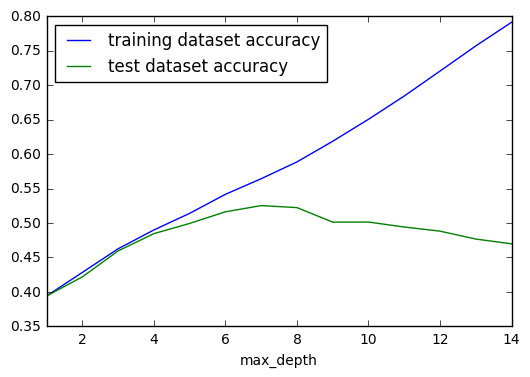

In [27]:
# plot validation curve

from sklearn import tree
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

# settings
nrows = 10000
sample = data[0:nrows]
cv = 5
max_depth = 15
 

# prepare input parameters 
y = sample.iloc[:,-1]
x = sample.iloc[:,:-1] 


modeler = tree.DecisionTreeClassifier(max_depth = 8)
modeler.fit(x,y)

# max_depth list
param_range = np.array([i for i in range(1,max_depth)])

train_scores, test_scores = validation_curve(modeler,x, y, param_name="max_depth", param_range=param_range,cv=cv, scoring=\
                                             "accuracy", n_jobs=10)

train_score = []
test_score = []

for i in range(len(train_scores)):
    train_score.append(train_scores[i].sum()/len(train_scores[i]))  
    test_score.append(test_scores[i].sum()/len(test_scores[i]))

train_score = pd.Series(train_score)
test_score = pd.Series(test_score)
depth = pd.Series(param_range)

stats = pd.concat([depth,train_score,test_score],axis=1)
stats.columns=['max_depth','training dataset accuracy','test dataset accuracy']

stats.plot(x=[stats.columns[0]],y=[stats.columns[1],stats.columns[2]],legend="Max_depth VS Predicting Accuracy").get_figure()



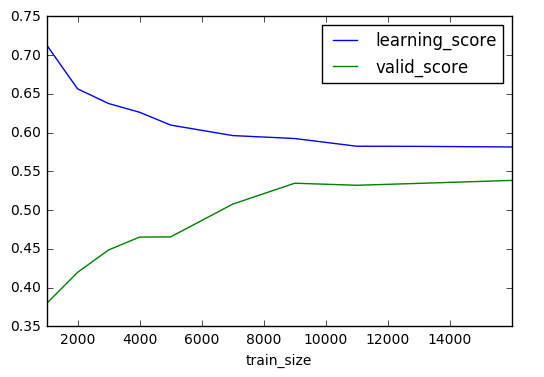

In [28]:
from sklearn.model_selection import learning_curve

# Plot learning curve
# remodel 
nrows = 20000
sample = data[0:nrows]
cv = 5

# prepare input parameters 
y = sample.iloc[:,-1]
x = sample.iloc[:,:-1] 

modeler = tree.DecisionTreeClassifier(max_depth = 8)
modeler.fit(x,y)

train_size = [1000,2000,3000,4000,5000,7000,9000,11000,13000,15990]

train_sizes, learning_scores, valid_scores = learning_curve(modeler, x, y, train_sizes=train_size, cv=cv)

learning_score = []
valid_score = []

for i in range(len(learning_scores)):
    learning_score.append(learning_scores[i].sum()/len(learning_scores[i]))  
    valid_score.append(valid_scores[i].sum()/len(valid_scores[i]))

learning_score = pd.Series(learning_score)
valid_score = pd.Series(valid_score)
train_size = pd.Series(train_size) 

stats = pd.concat([train_size,learning_score,valid_score],axis=1)
stats.columns=['train_size','learning_score','valid_score']

stats.plot(x=[stats.columns[0]],y=[stats.columns[1],stats.columns[2]],legend="Max_depth VS Predicting Accuracy").get_figure()

# PART E

Notice: logistic regression model is substantially slower than decision tree. So please don't use too many data

Such a poor validation curve $_$.. For train data, the larger C the better, but it's just the opposite as to test data. So I will use C=1.0 to build learning curve. 

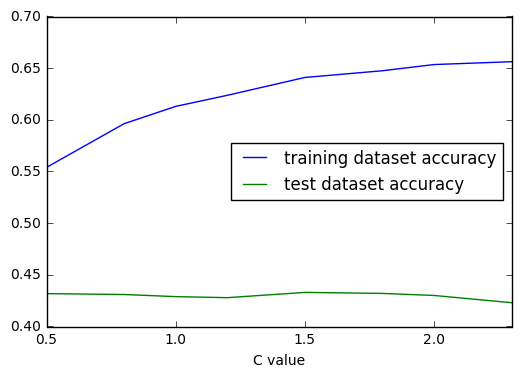

In [31]:
# PART E - validation curve
# it's going to take a while

from sklearn import linear_model

nrows = 1000
sample = data[0:nrows]
cv = 5
c = [0.5,0.8,1.0,1.2,1.5,1.8,2.0,2.3]
 

# prepare input parameters 
y = sample.iloc[:,-1]
x = sample.iloc[:,:-1] 

# creating modeler object
modeler = linear_model.LogisticRegression(penalty='l1', tol=1e-6)
modeler = modeler.fit(x,y)

# running validation_curve()
reg_train_scores, reg_test_scores = validation_curve(modeler,x, y, param_name="C", param_range=c,cv=cv, scoring=\
                                                     "accuracy", n_jobs=10)

reg_train_score = []
reg_test_score = []

for i in range(len(reg_train_scores)):
    reg_train_score.append(reg_train_scores[i].sum()/len(reg_train_scores[i]))  
    reg_test_score.append(reg_test_scores[i].sum()/len(reg_test_scores[i]))

reg_train_score = pd.Series(reg_train_score)
reg_test_score = pd.Series(reg_test_score)
c = pd.Series(c)

stats = pd.concat([c,reg_train_score,reg_test_score],axis=1)
stats.columns=['C value','training dataset accuracy','test dataset accuracy']

stats.plot(x=[stats.columns[0]],y=[stats.columns[1],stats.columns[2]],legend="C VS Predicting Accuracy").get_figure()

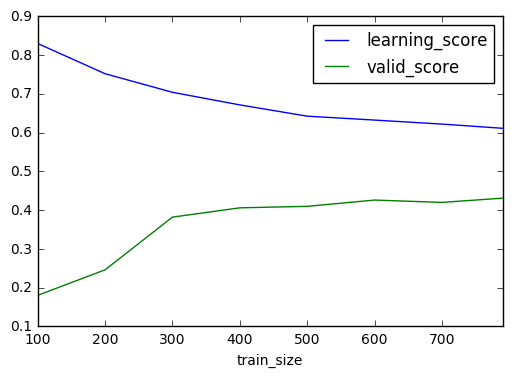

In [96]:
# PART E - learning Curve 
# this is even going to take longer 

from sklearn.model_selection import learning_curve

nrows = 1000
sample = data[0:nrows]
cv = 5
c = 1.0

# prepare input parameters 
y = sample.iloc[:,-1]
x = sample.iloc[:,:-1] 

linear_model.LogisticRegression(C=c,penalty='l1', tol=1e-6)
modeler.fit(x,y)

train_size = [100,200,300,400,500,600,700,790]

reg_train_sizes, reg_learning_scores, reg_valid_scores = learning_curve(modeler, x, y, train_sizes=train_size, cv=cv)

reg_learning_score = []
reg_valid_score = []

for i in range(len(reg_learning_scores)):
    reg_learning_score.append(reg_learning_scores[i].sum()/len(reg_learning_scores[i]))  
    reg_valid_score.append(reg_valid_scores[i].sum()/len(reg_valid_scores[i]))

reg_learning_score = pd.Series(reg_learning_score)
reg_valid_score = pd.Series(reg_valid_score)
reg_train_sizes = pd.Series(reg_train_sizes) 

stats = pd.concat([reg_train_sizes,reg_learning_score,reg_valid_score],axis=1)
stats.columns=['train_size','learning_score','valid_score']

stats.plot(x=[stats.columns[0]],y=[stats.columns[1],stats.columns[2]],legend="Max_depth VS Predicting Accuracy").get_figure()

# PART E discussion

When we talk about validation curve, I think logistic regression has more bias, which if measures the difference between training and test accuracies. As you could see from Decision Tree's curves, Decision Tree model gives more accurate predictions. 
But Decision tree also has more variance in terms of predicting accuracy than logistics. 

While for learning curve, decision tree is more accurate as well. As for predicting variance, the two models are close to each other. 